In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [153]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [154]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [155]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [156]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
df.isnull().sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
bsmtqual           37
bsmtcond           37
bsmtexposure       38
bsmtfintype1       37
bsmtfinsf1          0
bsmtfintype2       38
bsmtfinsf2          0
bsmtunfsf           0
totalbsmtsf         0
heating             0
heatingqc           0
centralair          0
electrical          1
firstflrsf          0
secondflrsf         0
lowqualfin

In [157]:
#dropping these features because there is at least more than 10% of the data missing.
col2drop = ['poolqc','fence','miscfeature','fireplacequ','alley','lotfrontage']
df = df.drop(col2drop, axis=1)

In [158]:
df[df['garagequal'].isnull()]

,id,mssubclass,mszoning,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
39,40,90,RL,6040,Pave,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,4,5,1955,1955,Gable,CompShg,AsbShng,Plywood,None,0.000,TA,TA,PConc,None,None,None,None,0,None,0,0,0,GasA,TA,N,FuseP,1152,0,0,1152,0,0,2,0,2,2,Fa,6,Typ,0,None,nan,None,0,0,None,None,N,0,0,0,0,0,0,0,6,2008,WD,AdjLand,82000,0,0,1,0,1
48,49,190,RM,4456,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,5,1920,2008,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,736,736,GasA,Gd,Y,SBrkr,736,716,0,1452,0,0,2,0,2,3,TA,8,Typ,0,None,nan,None,0,0,None,None,N,0,0,102,0,0,0,0,6,2009,New,Partial,113000,0,0,0,1,1
78,79,90,RL,10778,Pave,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,4,5,1968,1968,Hip,CompShg,HdBoard,HdBoard,None,0.000,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,1768,1768,GasA,TA,N,SBrkr,1768,0,0,1768,0,0,2,0,4,2,TA,8,Typ,0,None,nan,None,0,0,None,None,Y,0,0,0,0,0,0,0,4,2010,WD,Normal,136500,0,0,1,0,1
88,89,50,C (all),8470,Pave,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,1915,1982,Hip,CompShg,Plywood,Plywood,None,0.000,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,GasA,TA,N,SBrkr,1013,0,513,1526,0,0,1,0,2,1,Fa,6,Typ,0,None,nan,None,0,0,None,None,N,0,0,156,0,0,0,0,10,2009,ConLD,Abnorml,85000,0,0,0,0,1
89,90,20,RL,8070,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,4,5,1994,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,588,Unf,0,402,990,GasA,Ex,Y,SBrkr,990,0,0,990,1,0,1,0,3,1,TA,5,Typ,0,None,nan,None,0,0,None,None,Y,0,0,0,0,0,0,0,8,2007,WD,Normal,123600,0,0,1,0,1
99,100,20,RL,9320,Pave,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1959,1959,Gable,CompShg,Plywood,Plywood,None,0.000,TA,TA,CBlock,TA,TA,No,ALQ,569,Unf,0,381,950,GasA,Fa,Y,SBrkr,1225,0,0,1225,1,0,1,1,3,1,TA,6,Typ,0,None,nan,None,0,0,None,None,Y,352,0,0,0,0,0,400,1,2010,WD,Normal,128950,0,0,1,0,1
100,521,190,RL,10800,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,4,7,1900,2000,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,BrkTil,None,None,None,None,0,None,0,0,0,GasA,TA,N,FuseA,694,600,0,1294,0,0,2,0,3,2,TA,7,Typ,0,None,nan,None,0,0,None,None,N,220,114,210,0,0,0,0,8,2008,WD,Normal,106250,0,0,1,0,1
109,109,50,RM,8500,Pave,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Artery,Norm,1Fam,1.5Fin,5,7,1919,2005,Gable,CompShg,CemntBd,CmentBd,None,0.000,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,793,793,GasW,TA,N,FuseF,997,520,0,1517,0,0,2,0,3,1,Fa,7,Typ,0,None,nan,None,0,0,None,None,N,0,0,144,0,0,0,0,8,2007,WD,Normal,115000,0,0,0,1,1
126,126,190,RM,6780,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,2fmCon,1.5Fin,6,8,1935,1982,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000,TA,Fa,CBlock,TA,TA,Av,GLQ,490,Unf,0,30,520,GasA,Gd,N,SBrkr,520,0,234,754,1,0,1,0,2,1,TA,5,Typ,0,None,nan,None,0,0,None,None,N,53,0,0,0,0,0,0,6,2006,WD,Normal,84500,0,0,0,1,1
128,128,45,RM,4388,Pave,IR1,Bnk,AllPub,Inside,Gtl,OldTown,Feedr,Norm,1Fam,1.5Unf,5,7,1930,1950,Gable,CompShg,WdShing,Wd Sdng,None,0.000,TA,Gd,BrkTil,TA,TA,No,LwQ,116,Unf,0,556,672,GasA,Ex,Y,SBrkr,840,0,0,840,0,0,1,0,3,1,TA,5,Typ,1,None,nan,None,0,0,None,None,N,0,0,0,0,0,0,0,6,2007,WD,Normal,87000,0,0,0,1,1


In [159]:
#dropping rows with missing values. the missing values are MAR. if garage/bsmt info is missing in one observation,
#most of the garage/bsmt data will be missing for the row
df = df.dropna()

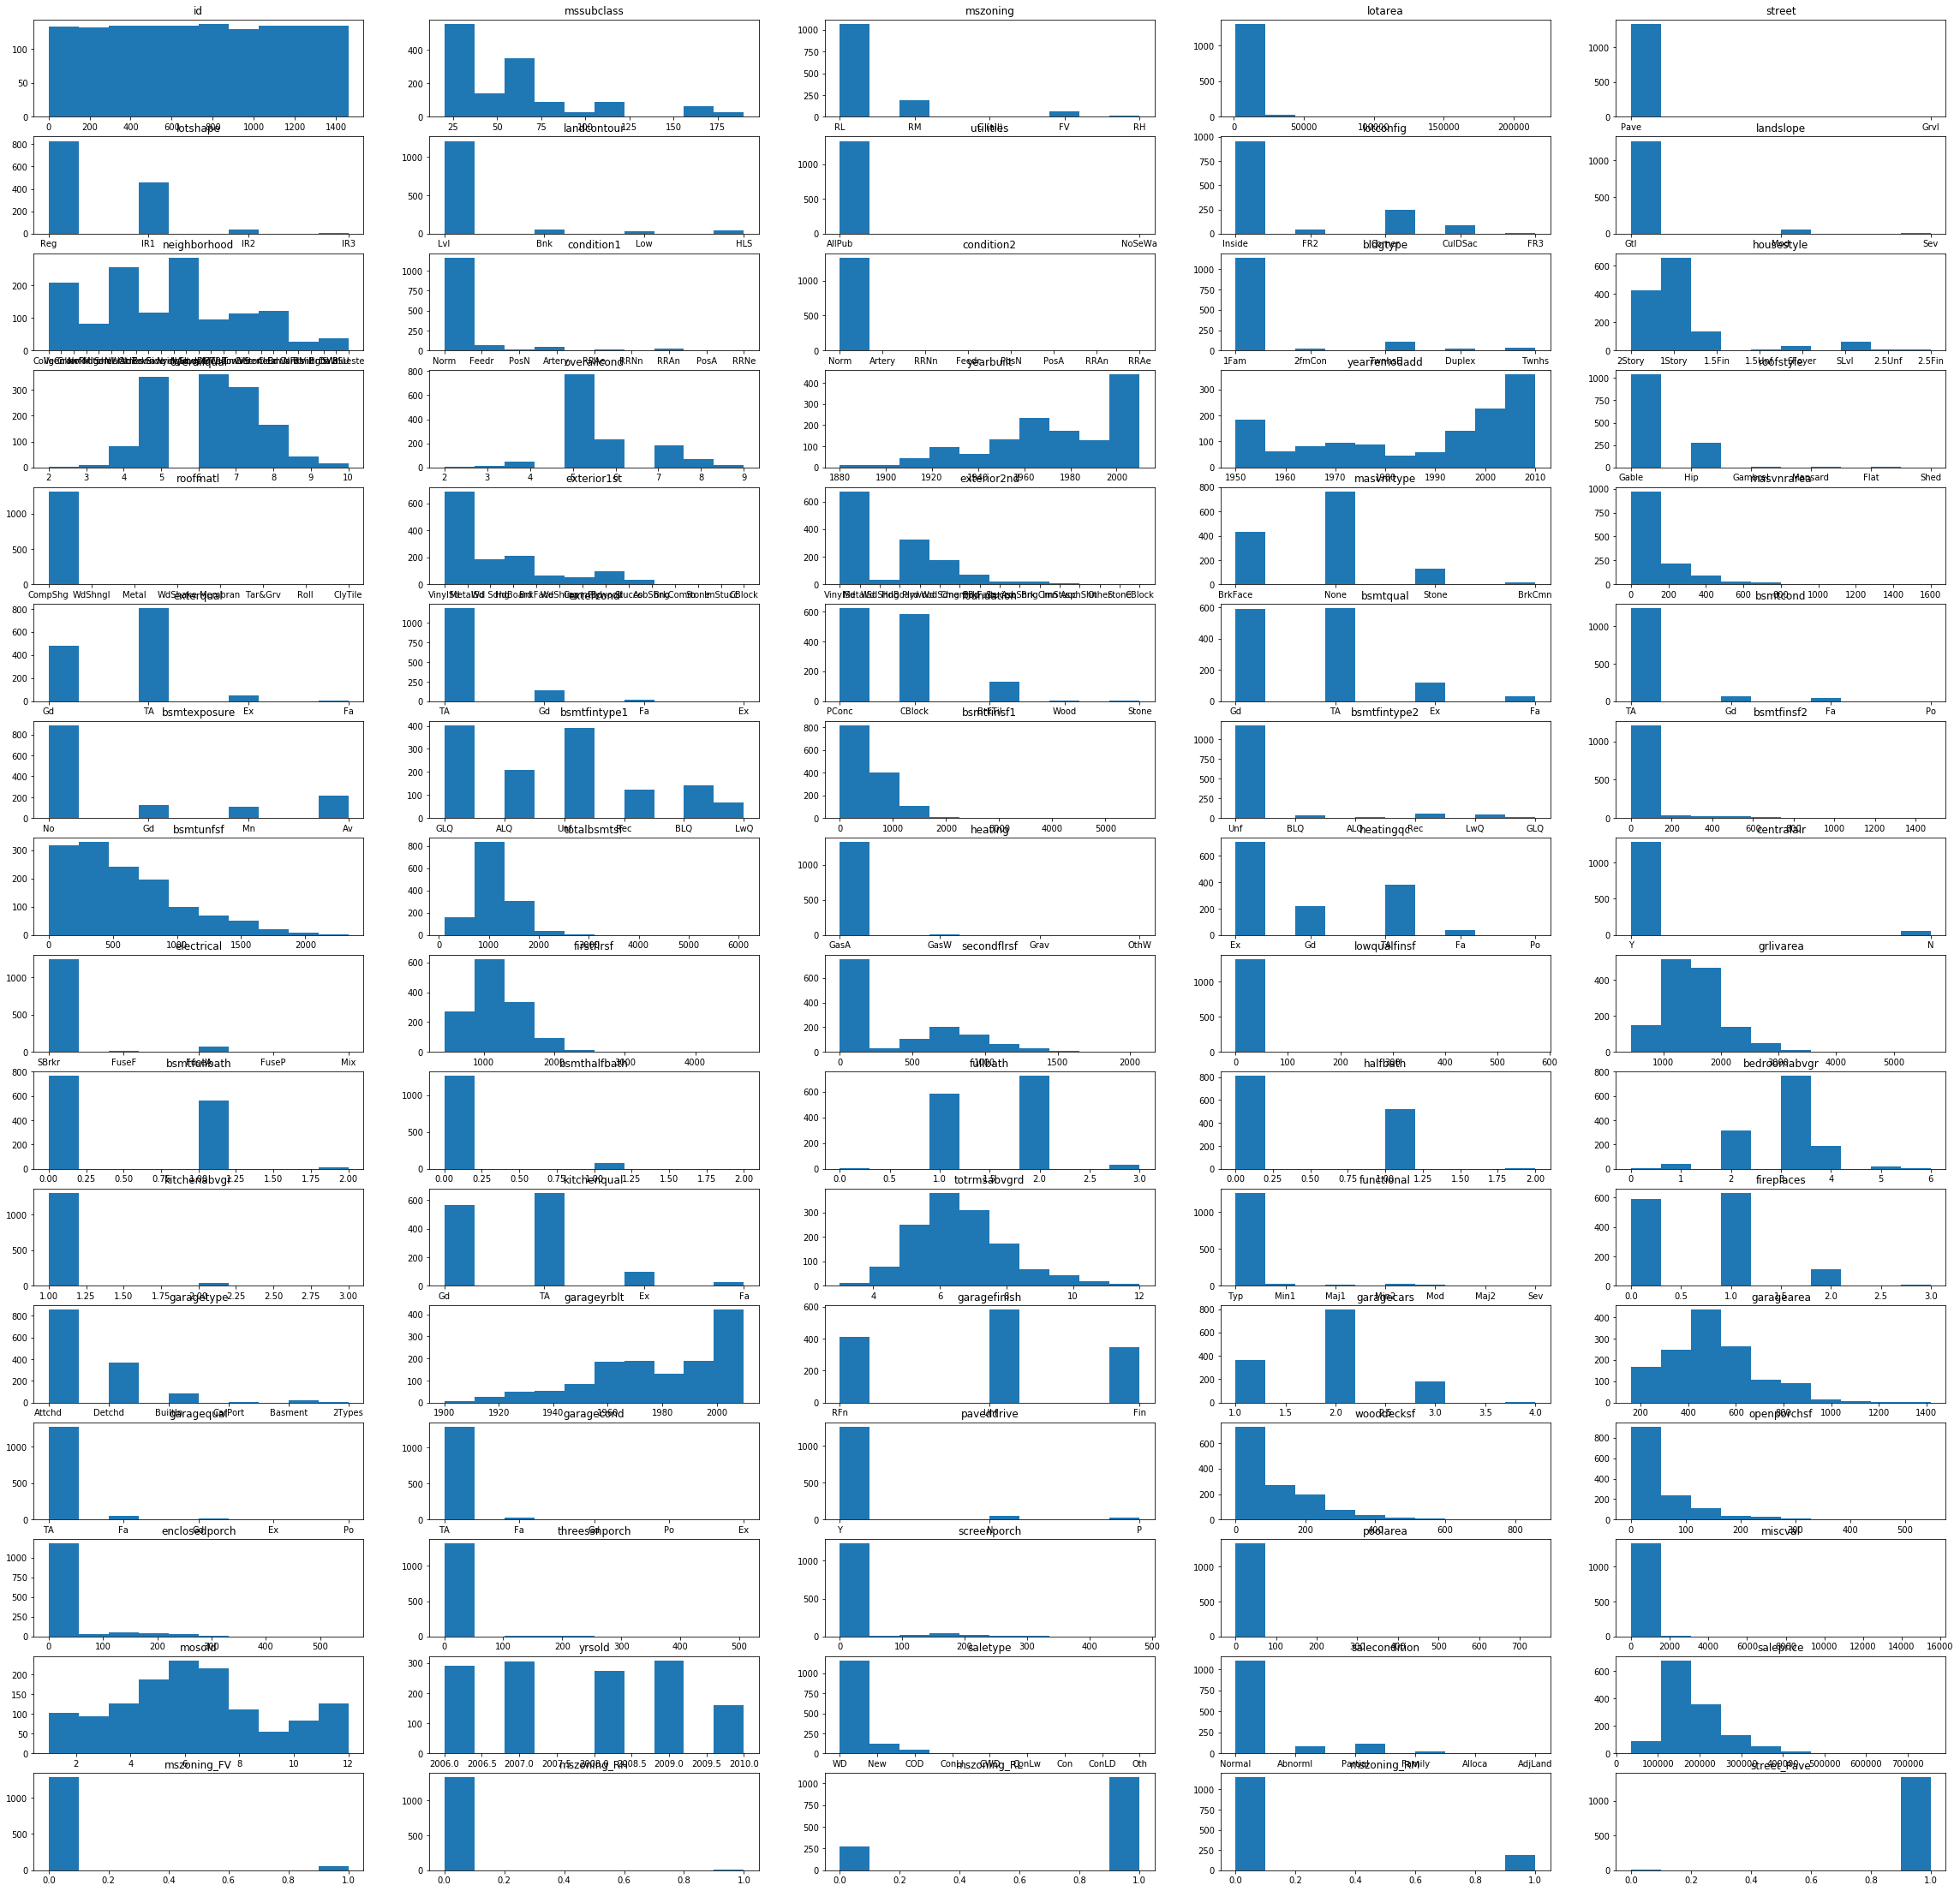

In [160]:
#histogram for all features
pd.reset_option('display.max_rows')
i = 1
plt.figure(figsize=(40,20))
for column_name in df.columns:
    plt.subplot(20,5,i)
    plt.hist(df[column_name])
    plt.title(df.columns[i-1])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()

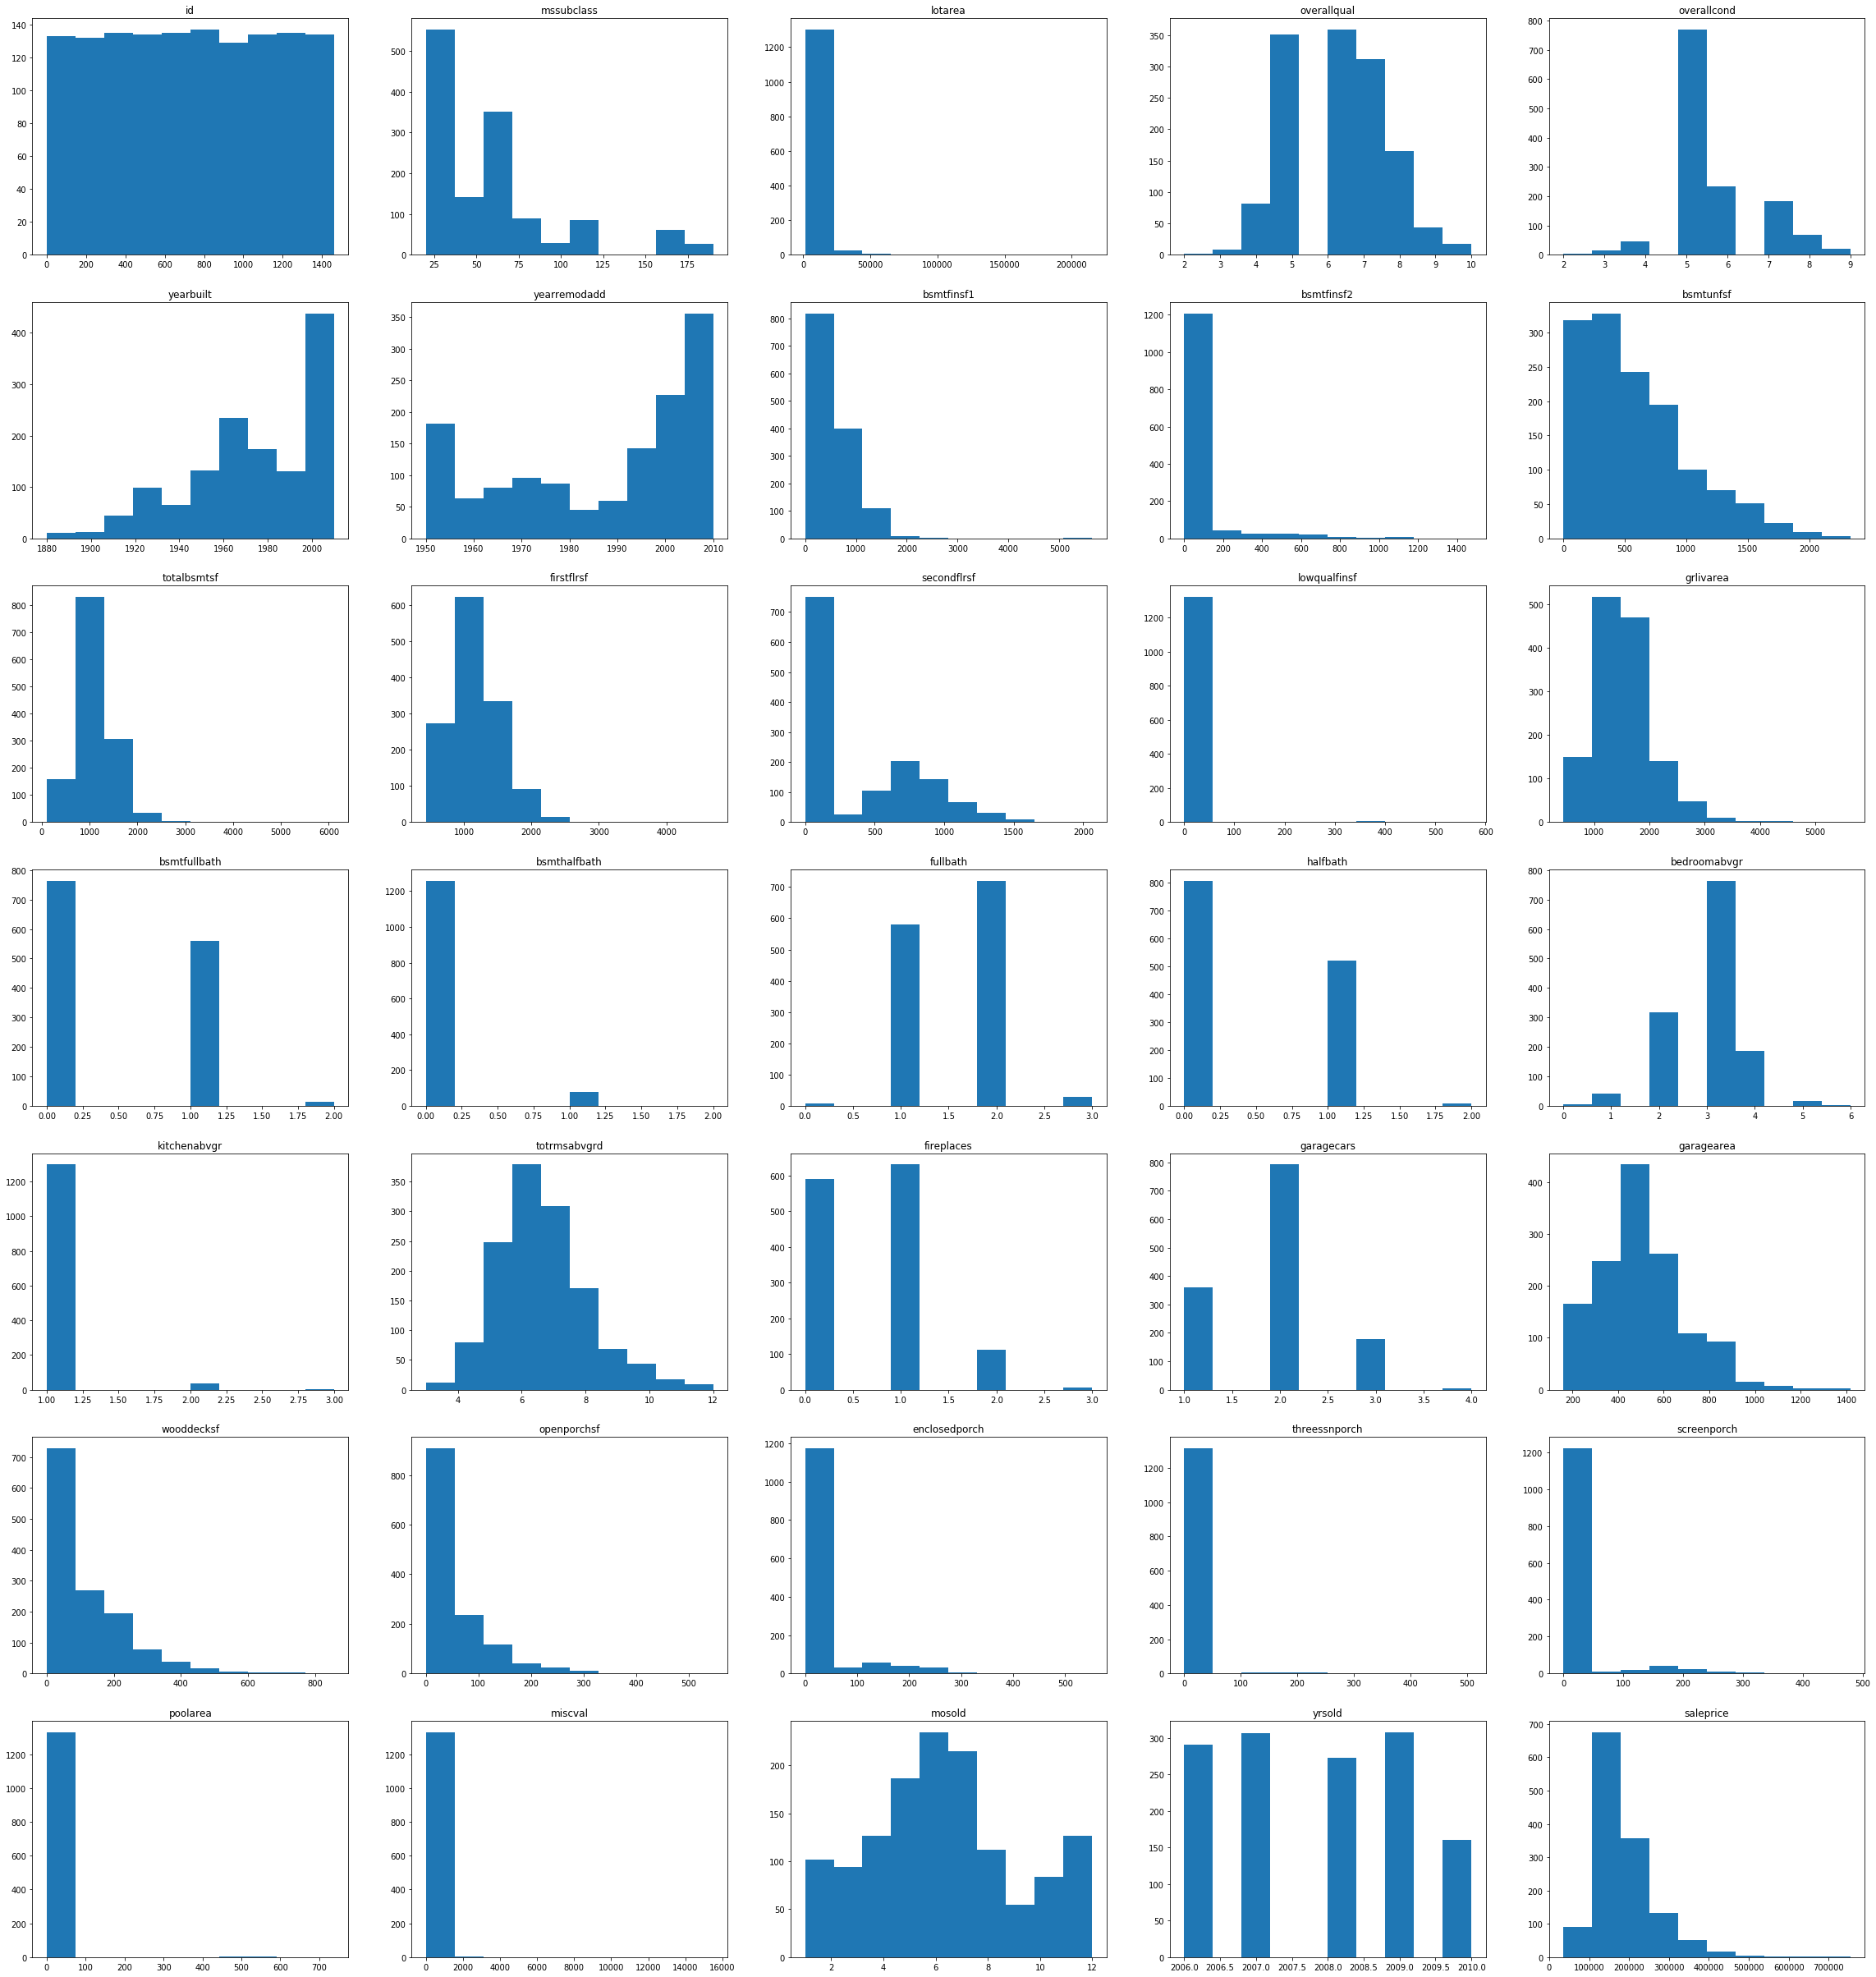

In [161]:
df.select_dtypes('int')
pd.reset_option('display.max_rows')
i = 1
plt.figure(figsize=(40,20))
for column_name in df.select_dtypes('int'):
    plt.subplot(8,5,i)
    plt.hist(df[column_name])
    plt.title(df.select_dtypes('int').columns[i-1])
    i = i+1
    
plt.subplots_adjust(bottom=-1)
plt.tight_layout()
plt.show()

winsorize_col = ['lotarea','bsmtfinsf1','bsmtfinsf2','totalbsmtsf','firstflrsf','lowqualfinsf','grlivarea',
                 'garagearea','screenporch','threessnporch','enclosedporch','openporchsf',
                 'wooddecksf','poolarea','miscval','saleprice']

In [162]:
#winsorize features that have outliers to 90th percentile
winsorize_col = ['lotarea','bsmtfinsf1','bsmtfinsf2','totalbsmtsf','firstflrsf','grlivarea',
                 'garagearea','enclosedporch','openporchsf',
                 'wooddecksf','saleprice']

for z in winsorize_col:
    df[z] = winsorize(df[z], (0,0.1))

Text(0.5, 1, 'Correlation matrix')

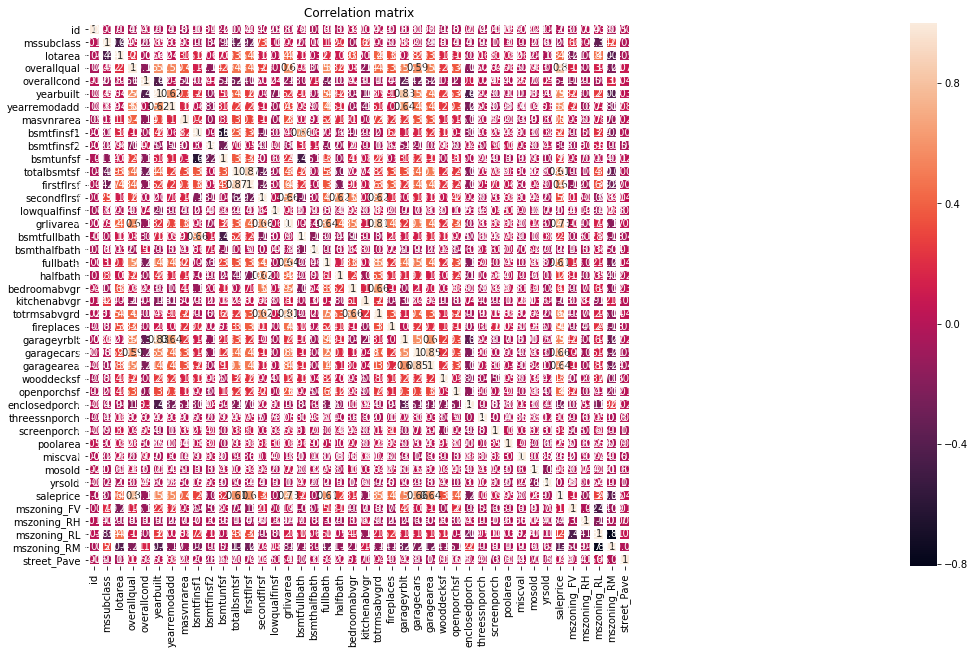

In [163]:
#checking for collinearity
plt.figure(figsize=(100,10))
sns.heatmap(df.corr(), square=True,annot=True,linewidths=3)
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Correlation matrix')

In [164]:
# Create correlation matrix
corr_matrix = df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [165]:
upper

,id,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
id,nan,0.017,-0.014,-0.044,0.012,-0.024,-0.028,-0.051,-0.008,-0.002,-0.010,-0.034,0.000,-0.003,-0.048,-0.008,0.010,-0.028,-0.000,-0.013,0.041,0.014,0.023,-0.018,-0.003,0.010,0.003,-0.048,-0.022,0.007,-0.044,0.001,0.059,-0.002,0.021,0.002,-0.030,-0.017,0.014,0.038,-0.035,0.006
mssubclass,nan,nan,-0.443,0.052,-0.098,0.056,0.039,0.031,-0.063,-0.069,-0.141,-0.286,-0.268,0.307,0.020,0.072,-0.011,-0.000,0.118,0.198,-0.066,0.239,0.015,-0.025,0.082,0.007,-0.068,-0.014,-0.014,-0.039,-0.041,-0.023,0.010,-0.022,-0.016,-0.022,-0.076,0.190,0.020,-0.342,0.273,-0.021
lotarea,nan,nan,nan,0.211,-0.007,0.042,0.043,0.155,0.174,0.067,0.090,0.358,0.435,0.115,0.014,0.424,0.108,0.032,0.198,0.090,0.319,0.001,0.410,0.330,0.028,0.295,0.339,0.178,0.158,-0.031,0.068,0.103,0.082,0.062,0.002,-0.030,0.434,-0.206,-0.068,0.469,-0.397,-0.051
overallqual,nan,nan,nan,nan,-0.163,0.571,0.549,0.401,0.125,-0.143,0.293,0.477,0.454,0.281,-0.017,0.595,0.083,-0.065,0.580,0.249,0.082,-0.135,0.443,0.377,0.546,0.592,0.542,0.251,0.371,-0.165,0.026,0.045,0.065,-0.029,0.063,-0.014,0.804,0.165,-0.053,0.133,-0.210,0.075
overallcond,nan,nan,nan,nan,nan,-0.417,0.035,-0.141,-0.044,0.075,-0.161,-0.245,-0.153,0.012,0.042,-0.126,-0.070,0.120,-0.212,-0.074,0.023,-0.071,-0.064,-0.032,-0.337,-0.250,-0.211,-0.032,-0.105,0.102,0.024,0.054,-0.004,0.077,-0.012,0.056,-0.106,-0.119,-0.035,-0.053,0.153,0.045
yearbuilt,nan,nan,nan,nan,nan,nan,0.617,0.299,0.209,-0.095,0.148,0.410,0.269,0.007,-0.160,0.225,0.175,-0.055,0.487,0.228,-0.081,-0.176,0.099,0.111,0.825,0.524,0.474,0.265,0.316,-0.433,0.029,-0.071,0.001,-0.033,0.004,-0.008,0.575,0.234,-0.062,0.261,-0.398,0.036
yearremodadd,nan,nan,nan,nan,nan,nan,nan,0.168,0.068,-0.130,0.172,0.274,0.248,0.121,-0.064,0.297,0.099,-0.024,0.460,0.169,-0.074,-0.154,0.175,0.090,0.642,0.459,0.407,0.251,0.300,-0.246,0.039,-0.053,0.003,-0.001,0.015,0.035,0.570,0.207,-0.087,0.078,-0.167,0.082
masvnrarea,nan,nan,nan,nan,nan,nan,nan,nan,0.196,-0.073,0.105,0.315,0.301,0.170,-0.062,0.346,0.079,0.016,0.272,0.193,0.109,-0.007,0.290,0.229,0.250,0.364,0.346,0.156,0.162,-0.134,0.015,0.052,0.009,-0.029,-0.013,-0.002,0.397,0.036,-0.027,0.087,-0.104,0.022
bsmtfinsf1,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.006,-0.618,0.377,0.336,-0.180,-0.054,0.067,0.656,0.067,0.007,-0.040,-0.116,-0.042,-0.016,0.202,0.119,0.163,0.229,0.181,0.073,-0.144,0.032,0.054,0.048,0.013,-0.013,0.025,0.290,-0.065,-0.013,0.219,-0.200,-0.003
bsmtfinsf2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-0.270,0.040,0.054,-0.113,0.008,-0.063,0.138,0.116,-0.117,-0.062,0.020,-0.021,-0.056,0.025,-0.116,-0.108,-0.049,0.066,-0.071,0.045,-0.029,0.060,0.070,0.039,-0.034,0.033,-0.080,-0.080,-0.007,0.105,-0.065,-0.056


In [166]:
#features with higher correlation score than 0.7
col_drop = ['totalbsmtsf','secondflrsf','grlivarea','bedroomabvgr','garageyrblt','garagearea']

In [167]:
#dropping highly correlated features
df = df.drop(col_drop, axis=1)

In [168]:
# Create correlation matrix
corr_matrix = df.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [169]:
#split data into data types and remove id column
categorical = df.select_dtypes('object').columns.tolist()
df = df.drop('id', axis=1)


In [183]:
#preprocess data
final_df = df.copy()

final_df = pd.concat([df, pd.get_dummies(df[categorical], drop_first=True)], axis=1)
final_df = final_df.drop(categorical, axis=1)
y = final_df['saleprice']
x = final_df.drop('saleprice', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=465)

In [188]:
x_train_lr = sm.add_constant(x_train)

In [189]:
results = sm.OLS(y_train, x_train_lr).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     56.22
Date:                Fri, 21 Aug 2020   Prob (F-statistic):               0.00
Time:                        21:44:07   Log-Likelihood:                -11807.
No. Observations:                1070   AIC:                         2.404e+04
Df Residuals:                     857   BIC:                         2.510e+04
Df Model:                         212                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4.131e+05   8.15e+05     -0.507      0.612   -2.01e+06    1.19e+06
mssubclass              -53.3543     77.379     -0.690      0.491    -205.229      98.520
lotarea                   1.9439      0.320      6.081      0.000       1.316       2.571
overallqual            7118.4514    926.672      7.682      0.000    5299.638    8937.265
overallcond            5278.1305    795.694      6.633      0.000    3716.394    6839.867
yearbuilt               218.9713     72.704      3.012      0.003      76.273     361.669
yearremodadd             66.3896     50.734      1.309      0.191     -33.188     165.967
masvnrarea                3.4705      4.747      0.731      0.465      -5.847      12.788
bsmtfinsf1               12.9549      4.253      3.046      0.002       4.608      21.302
bsmtfinsf2               30.2866     74.077      0.409      0.683    -115.108     175.681
bsmtunfsf                 2.8693      3.382      0.848      0.396      -3.769       9.507
firstflrsf               49.4490      4.585     10.784      0.000      40.449      58.449
lowqualfinsf            -25.5523     17.932     -1.425      0.155     -60.749       9.644
bsmtfullbath           2202.9363   1722.593      1.279      0.201   -1178.059    5583.931
bsmthalfbath          -3011.2997   2674.115     -1.126      0.260   -8259.882    2237.283
fullbath               4408.7112   1872.047      2.355      0.019     734.378    8083.045
halfbath               2517.2324   1831.537      1.374      0.170   -1077.590    6112.055
kitchenabvgr          -1.636e+04   6437.842     -2.542      0.011    -2.9e+04   -3726.438
totrmsabvgrd           1660.1371    701.674      2.366      0.018     282.937    3037.337
fireplaces             3620.2043   1154.568      3.136      0.002    1354.093    5886.316
garagecars             6413.8149   1408.380      4.554      0.000    3649.537    9178.093
wooddecksf               16.6710      6.512      2.560      0.011       3.890      29.451
openporchsf              46.7430     14.875      3.142      0.002      17.548      75.938
enclosedporch            10.4450     19.100      0.547      0.585     -27.043      47.933
threessnporch            14.9341     17.782      0.840      0.401     -19.967      49.836
screenporch              32.0220     10.271      3.118      0.002      11.864      52.180
poolarea                 55.9615     14.875      3.762      0.000      26.766      85.157
miscval                   0.8705      1.087      0.801      0.424      -1.264       3.005
mosold                  139.9560    215.925      0.648      0.517    -283.847     563.759
yrsold                  -94.3196    459.727     -0.205      0.837    -996.641     808.002
mszoning_FV            1.778e+04   5321.475      3.341      0.001    7336.822    2.82e+04
mszoning_RH            

Adj. R-squared is .916. this implies that 8.4% of the variance is not explained by the model. the AIC is
24040 and BIC is 25100.

In [191]:
x_test_lr = sm.add_constant(x_test)
results = sm.OLS(y_test, x_test_lr).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     17.30
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           1.46e-35
Time:                        21:47:11   Log-Likelihood:                -2836.2
No. Observations:                 268   AIC:                             6028.
Df Residuals:                      90   BIC:                             6668.
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
mssubclass              -25.9919    345.317     -0.075      0.940    -712.025     660.041
lotarea                   4.1871      1.105      3.790      0.000       1.992       6.382
overallqual            3498.8283   3004.830      1.164      0.247   -2470.792    9468.448
overallcond            3551.0267   3036.413      1.169      0.245   -2481.339    9583.392
yearbuilt               268.1297    279.553      0.959      0.340    -287.250     823.510
yearremodadd             55.3677    171.395      0.323      0.747    -285.139     395.875
masvnrarea               36.3184     17.334      2.095      0.039       1.882      70.755
bsmtfinsf1               -0.8948     15.314     -0.058      0.954     -31.319      29.529
bsmtfinsf2              -67.1973    209.504     -0.321      0.749    -483.414     349.019
bsmtunfsf               -12.9974     13.338     -0.974      0.332     -39.495      13.500
firstflrsf               49.1134     17.887      2.746      0.007      13.578      84.649
lowqualfinsf            -34.7012     73.312     -0.473      0.637    -180.347     110.945
bsmtfullbath           -688.2737   5261.486     -0.131      0.896   -1.11e+04    9764.586
bsmthalfbath           1.346e+04   7456.434      1.805      0.074   -1354.227    2.83e+04
fullbath               8539.5951   8186.366      1.043      0.300   -7724.051    2.48e+04
halfbath               7568.6676   6460.249      1.172      0.244   -5265.746    2.04e+04
kitchenabvgr           -2.02e+04    2.7e+04     -0.748      0.456   -7.39e+04    3.35e+04
totrmsabvgrd           1939.9758   2472.679      0.785      0.435   -2972.433    6852.384
fireplaces            -3653.7534   3948.795     -0.925      0.357   -1.15e+04    4191.216
garagecars              1.04e+04   4722.495      2.202      0.030    1015.090    1.98e+04
wooddecksf               47.0971     20.286      2.322      0.023       6.795      87.399
openporchsf              40.3082     43.976      0.917      0.362     -47.057     127.674
enclosedporch            68.6748     76.028      0.903      0.369     -82.368     219.718
threessnporch           209.6906    101.217      2.072      0.041       8.606     410.775
screenporch              21.5317     40.907      0.526      0.600     -59.737     102.800
poolarea                 29.3144    286.543      0.102      0.919    -539.953     598.582
miscval                   0.5569     15.733      0.035      0.972     -30.699      31.812
mosold                  446.5188    628.548      0.710      0.479    -802.202    1695.240
yrsold                -1495.8912   1273.126     -1.175      0.243   -4025.178    1033.395
mszoning_FV            4.331e+04   3.53e+04      1.227      0.223   -2.68e+04    1.13e+05
mszoning_RH            4.738e+04   3.88e+04      1.221      0.225   -2.97e+04    1.24e+05
mszoning_RL            

Adj. R-squared of .915, F-stat:17.3,AIC 6028, and BIC 6668

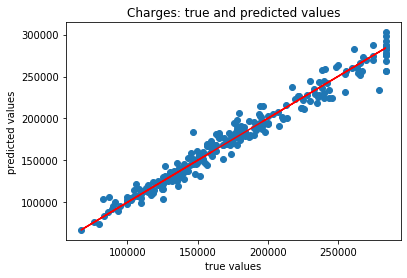

Mean absolute error of the prediction is: 6644.2281449716775
Mean squared error of the prediction is: 91139425.85864405
Root mean squared error of the prediction is: 9546.69711778079
Mean absolute percentage error of the prediction is: 3.8633321415124136


In [195]:
Y_pred = results.predict(x_test_lr)

plt.scatter(y_test, Y_pred)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, Y_pred)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, Y_pred)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, Y_pred)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - Y_pred) / y_test)) * 100))

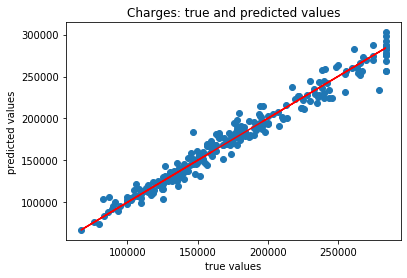

R-squared of the model in training set is: 0.9329137482619013
-----Test set statistics-----
R-squared of the model in test set is: 0.836890866225121
Mean absolute error of the prediction is: 14286.418540535333
Mean squared error of the prediction is: 520669388.0221192
Root mean squared error of the prediction is: 22818.181084874388
Mean absolute percentage error of the prediction is: 8.454676901448387
Cross Value Scores: [0.821 0.851 0.852]


In [196]:
y_preds = results.predict(x_test)

lrm = LinearRegression()

lrm.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(x_train)
y_preds_test = lrm.predict(x_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lrm.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('Cross Value Scores:', cross_val_score(lrm, x, y, cv=3).round(3))

In [197]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

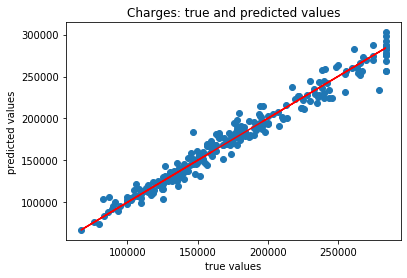

R-squared of the model in training set is: 0.9221726113222656
-----Test set statistics-----
R-squared of the model in test set is: 0.8423986606623413
Mean absolute error of the prediction is: 14144.7968574441
Mean squared error of the prediction is: 503087662.8752171
Root mean squared error of the prediction is: 22429.61575406982
Mean absolute percentage error of the prediction is: 8.37411405557209
Cross Value Scores: [0.9   0.877 0.865]


In [202]:
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(x_train)
y_preds_test = ridge_cv.predict(x_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(ridge_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('Cross Value Scores:', cross_val_score(ridge_cv, x, y, cv=3).round(3))

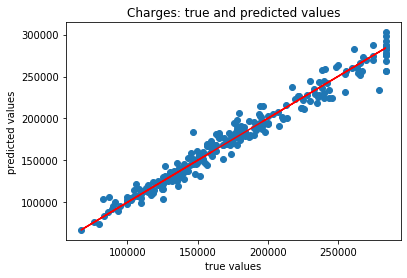

R-squared of the model in training set is: 0.9148866087985236
-----Test set statistics-----
R-squared of the model in test set is: 0.8381808990339045
Mean absolute error of the prediction is: 14528.45314432482
Mean squared error of the prediction is: 516551405.3099748
Root mean squared error of the prediction is: 22727.767275075104
Mean absolute percentage error of the prediction is: 8.602176412203269
Cross Value Scores: [0.902 0.875 0.864]


In [204]:
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(x_train)
y_preds_test = lasso_cv.predict(x_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(lasso_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('Cross Value Scores:', cross_val_score(lasso_cv, x, y, cv=3).round(3))

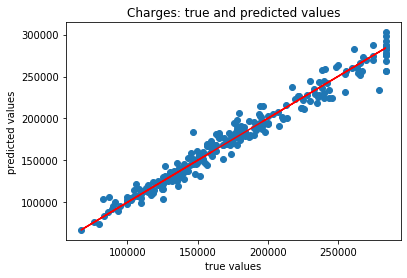

R-squared of the model in training set is: 0.9254670984676898
-----Test set statistics-----
R-squared of the model in test set is: 0.8430797210246035
Mean absolute error of the prediction is: 14026.75969608666
Mean squared error of the prediction is: 500913613.6738115
Root mean squared error of the prediction is: 22381.099474194994
Mean absolute percentage error of the prediction is: 8.302909585795765
Cross Value Scores: [0.896 0.875 0.862]


In [203]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(x_train)
y_preds_test = elasticnet_cv.predict(x_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))
print('Cross Value Scores:', cross_val_score(elasticnet_cv, x, y, cv=3).round(3))

elasticnet has the best R2 value at .843 and the lowest MAE and MSE. It is the best algorithm to use out of these 4.